In [1]:
import pandas as pd
import numpy as np
grid = pd.read_pickle("outputs_in_instab_strip.pkl")

# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

size = X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)
Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])
torch.Size([122651, 30, 2])


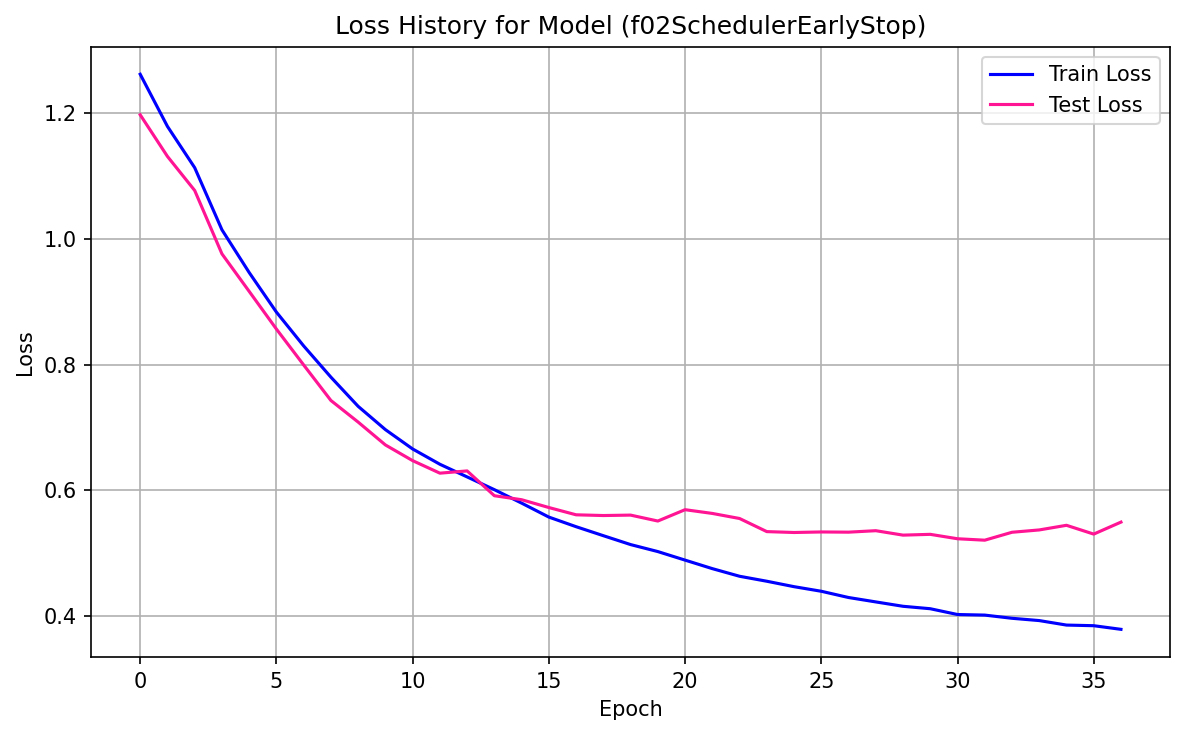

37


In [3]:
import pickle
import matplotlib.pyplot as plt

suffix = "f02SchedulerEarlyStop"
#suffix = "d05s05f02SchedulerEarlyStop"  # <-- Uncomment this to plot the other model

with open(f"train_history_{suffix}.pkl", "rb") as f:
    history_train = pickle.load(f)

with open(f"val_history_{suffix}.pkl", "rb") as f:
    history_test = pickle.load(f)
    
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(history_train, label="Train Loss", color='blue')
plt.plot(history_test, label="Test Loss", color='deeppink')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss History for Model ({suffix})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

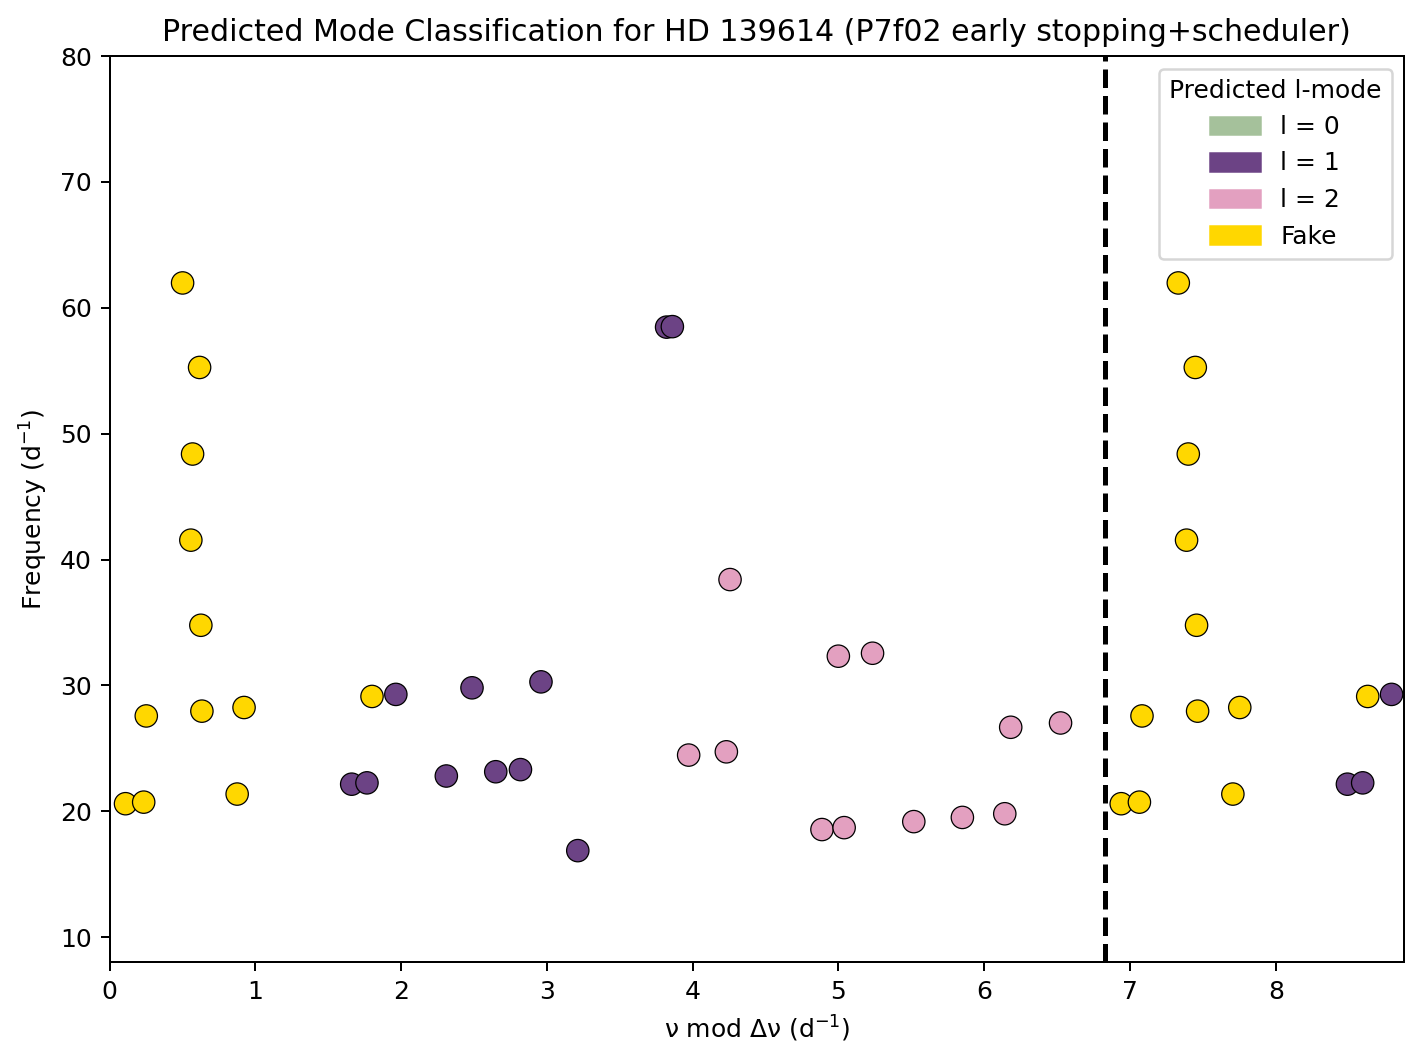

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Frequencies and features
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    16.87165, 32.55347, 38.40601, 58.46084, 28.24243, 27.01307, 20.59936,
    18.54655, 18.69868, 19.17648, 19.50970, 19.80056, 20.72404, 22.15081,
    22.25558, 22.79990, 23.13894, 23.30843, 24.46210, 24.72073, 26.67124,
    27.57177, 29.12013, 29.28361, 29.80605, 30.27912, 32.31897, 58.50036
])
delta_nu = 6.83
nu_mod_delta_nu = np.mod(frequencies, delta_nu)
X_hd = torch.tensor(np.stack([frequencies, nu_mod_delta_nu], axis=1), dtype=torch.float32).unsqueeze(0)

# Model definition
class PointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()
        a = 3
        nfeat = 64
        self.conv_1_a = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = torch.nn.Conv1d(nfeat, nfeat, kernel_size=a)
        self.bn_1 = torch.nn.BatchNorm1d(nfeat)
        self.bn_2 = torch.nn.BatchNorm1d(nfeat)
    def forward(self, x):
        batch_size, num_points, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)
        x_modnu = x[:, :, 1].unsqueeze(1)
        x_freq = torch.nn.functional.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = torch.nn.functional.pad(x_modnu, (1, 1), mode='circular')
        x = self.conv_1_a(x_freq) + self.conv_1_b(x_modnu)
        x = torch.nn.functional.relu(self.bn_1(x))
        x = torch.nn.functional.relu(self.bn_2(self.conv_2(x)))
        x = torch.nn.functional.max_pool1d(x, kernel_size=x.size(-1))
        return x.view(batch_size, -1)

class SegmentationPointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension)
        nfeat = 64
        nhidden = 64
        self.fc_1 = torch.nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = torch.nn.Linear(nhidden, num_classes)
    def forward(self, x):
        global_feat = self.base_pointnet(x).unsqueeze(1).repeat(1, x.shape[1], 1)
        x = torch.cat([x, global_feat], dim=2)
        x = torch.nn.functional.relu(self.fc_1(x))
        return torch.nn.functional.log_softmax(self.fc_2(x), dim=2)

model_path = "segmentation_pointnet_f02SchedulerEarlyStop.pth"
model = SegmentationPointNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Predict
with torch.no_grad():
    logits_hd = model(X_hd)
    probs_hd = torch.exp(logits_hd)[0].numpy()
    preds_hd = np.argmax(probs_hd, axis=1)

# Visualization
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', 3: 'gold'}
colors_pred = [color_map[int(p)] for p in preds_hd]
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l = 0'),
    mpatches.Patch(color=color_map[1], label='l = 1'),
    mpatches.Patch(color=color_map[2], label='l = 2'),
    mpatches.Patch(color=color_map[3], label='Fake')
]

fig, ax = plt.subplots(figsize=(8, 6), dpi=180)
ax.scatter(nu_mod_delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
ax.scatter(nu_mod_delta_nu + delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
ax.axvline(delta_nu, color='black', linestyle='--', linewidth=2)
ax.set_xlim(0, delta_nu * 1.3)
ax.set_ylim(8, 80)
ax.legend(handles=legend_elements, title="Predicted l-mode", loc="upper right")
ax.set_title("Predicted Mode Classification for HD 139614 (P7f02 early stopping+scheduler)")
ax.set_xlabel("ν mod Δν (d$^{-1}$)")
ax.set_ylabel("Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()


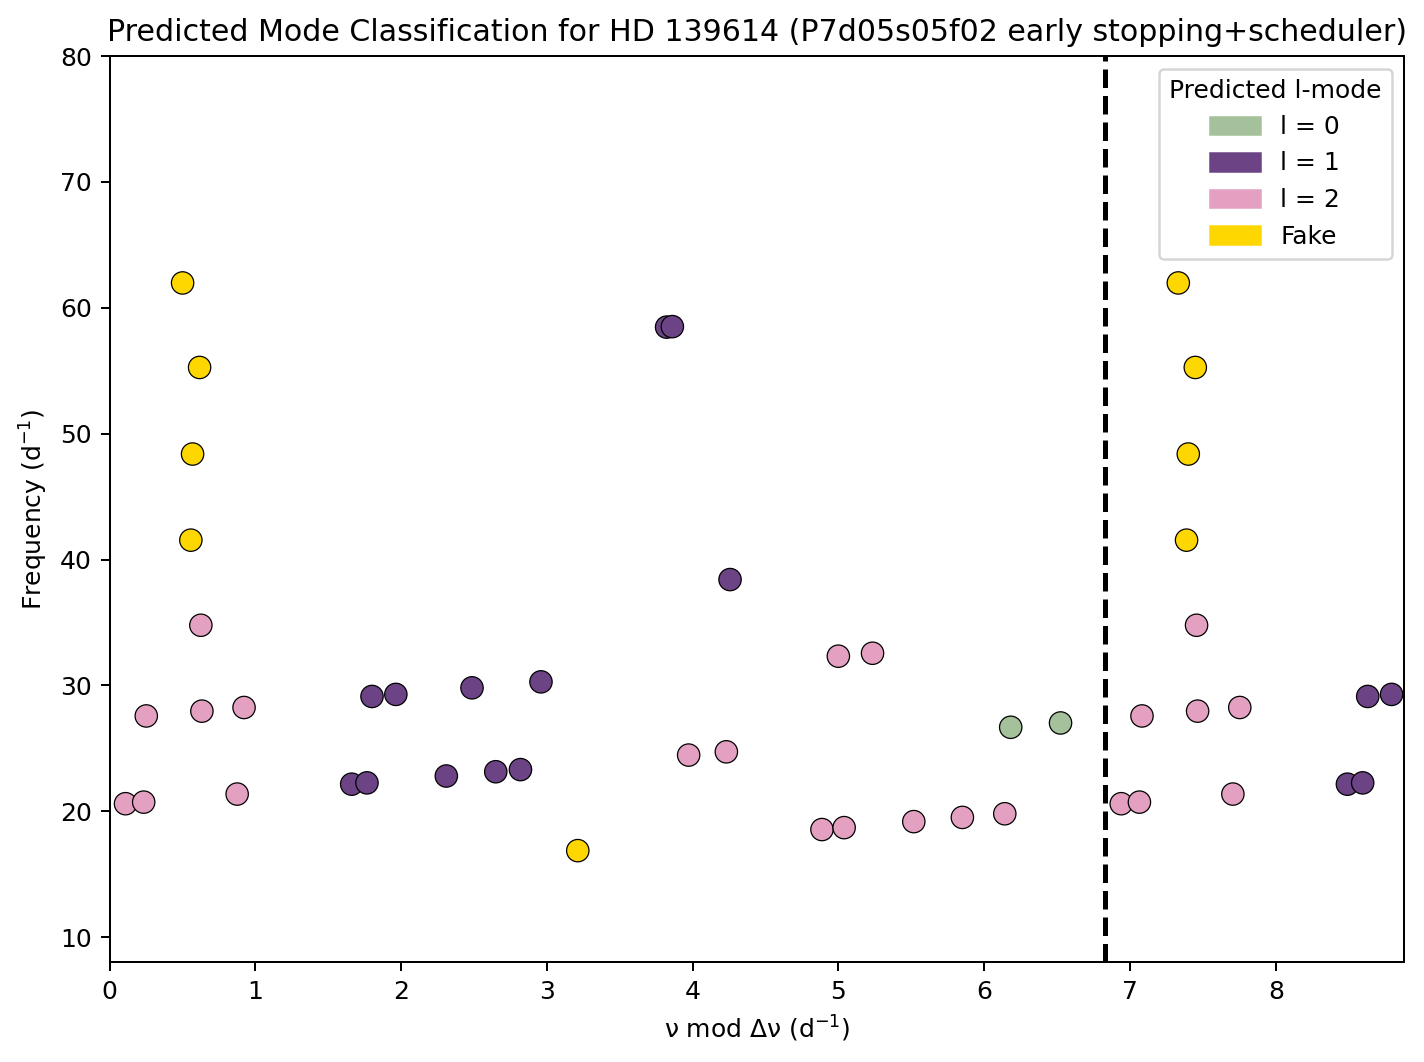

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Frequencies and features
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    16.87165, 32.55347, 38.40601, 58.46084, 28.24243, 27.01307, 20.59936,
    18.54655, 18.69868, 19.17648, 19.50970, 19.80056, 20.72404, 22.15081,
    22.25558, 22.79990, 23.13894, 23.30843, 24.46210, 24.72073, 26.67124,
    27.57177, 29.12013, 29.28361, 29.80605, 30.27912, 32.31897, 58.50036
])
delta_nu = 6.83
nu_mod_delta_nu = np.mod(frequencies, delta_nu)
X_hd = torch.tensor(np.stack([frequencies, nu_mod_delta_nu], axis=1), dtype=torch.float32).unsqueeze(0)

# Model definition
class PointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()
        a = 3
        nfeat = 64
        self.conv_1_a = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = torch.nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = torch.nn.Conv1d(nfeat, nfeat, kernel_size=a)
        self.bn_1 = torch.nn.BatchNorm1d(nfeat)
        self.bn_2 = torch.nn.BatchNorm1d(nfeat)
    def forward(self, x):
        batch_size, num_points, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)
        x_modnu = x[:, :, 1].unsqueeze(1)
        x_freq = torch.nn.functional.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = torch.nn.functional.pad(x_modnu, (1, 1), mode='circular')
        x = self.conv_1_a(x_freq) + self.conv_1_b(x_modnu)
        x = torch.nn.functional.relu(self.bn_1(x))
        x = torch.nn.functional.relu(self.bn_2(self.conv_2(x)))
        x = torch.nn.functional.max_pool1d(x, kernel_size=x.size(-1))
        return x.view(batch_size, -1)

class SegmentationPointNet(torch.nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension)
        nfeat = 64
        nhidden = 64
        self.fc_1 = torch.nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = torch.nn.Linear(nhidden, num_classes)
    def forward(self, x):
        global_feat = self.base_pointnet(x).unsqueeze(1).repeat(1, x.shape[1], 1)
        x = torch.cat([x, global_feat], dim=2)
        x = torch.nn.functional.relu(self.fc_1(x))
        return torch.nn.functional.log_softmax(self.fc_2(x), dim=2)

model_path = "segmentation_pointnet_f02SchedulerEarlyStop.pth"
model_path = "segmentation_pointnet_d05s05f02SchedulerEarlyStop.pth"
model = SegmentationPointNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Predict
with torch.no_grad():
    logits_hd = model(X_hd)
    probs_hd = torch.exp(logits_hd)[0].numpy()
    preds_hd = np.argmax(probs_hd, axis=1)

# Visualization
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', 3: 'gold'}
colors_pred = [color_map[int(p)] for p in preds_hd]
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l = 0'),
    mpatches.Patch(color=color_map[1], label='l = 1'),
    mpatches.Patch(color=color_map[2], label='l = 2'),
    mpatches.Patch(color=color_map[3], label='Fake')
]

fig, ax = plt.subplots(figsize=(8, 6), dpi=180)
ax.scatter(nu_mod_delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
ax.scatter(nu_mod_delta_nu + delta_nu, frequencies, c=colors_pred, edgecolors='black', linewidths=0.5, s=80)
ax.axvline(delta_nu, color='black', linestyle='--', linewidth=2)
ax.set_xlim(0, delta_nu * 1.3)
ax.set_ylim(8, 80)
ax.legend(handles=legend_elements, title="Predicted l-mode", loc="upper right")
ax.set_title("Predicted Mode Classification for HD 139614 (P7d05s05f02 early stopping+scheduler)")
ax.set_xlabel("ν mod Δν (d$^{-1}$)")
ax.set_ylabel("Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()


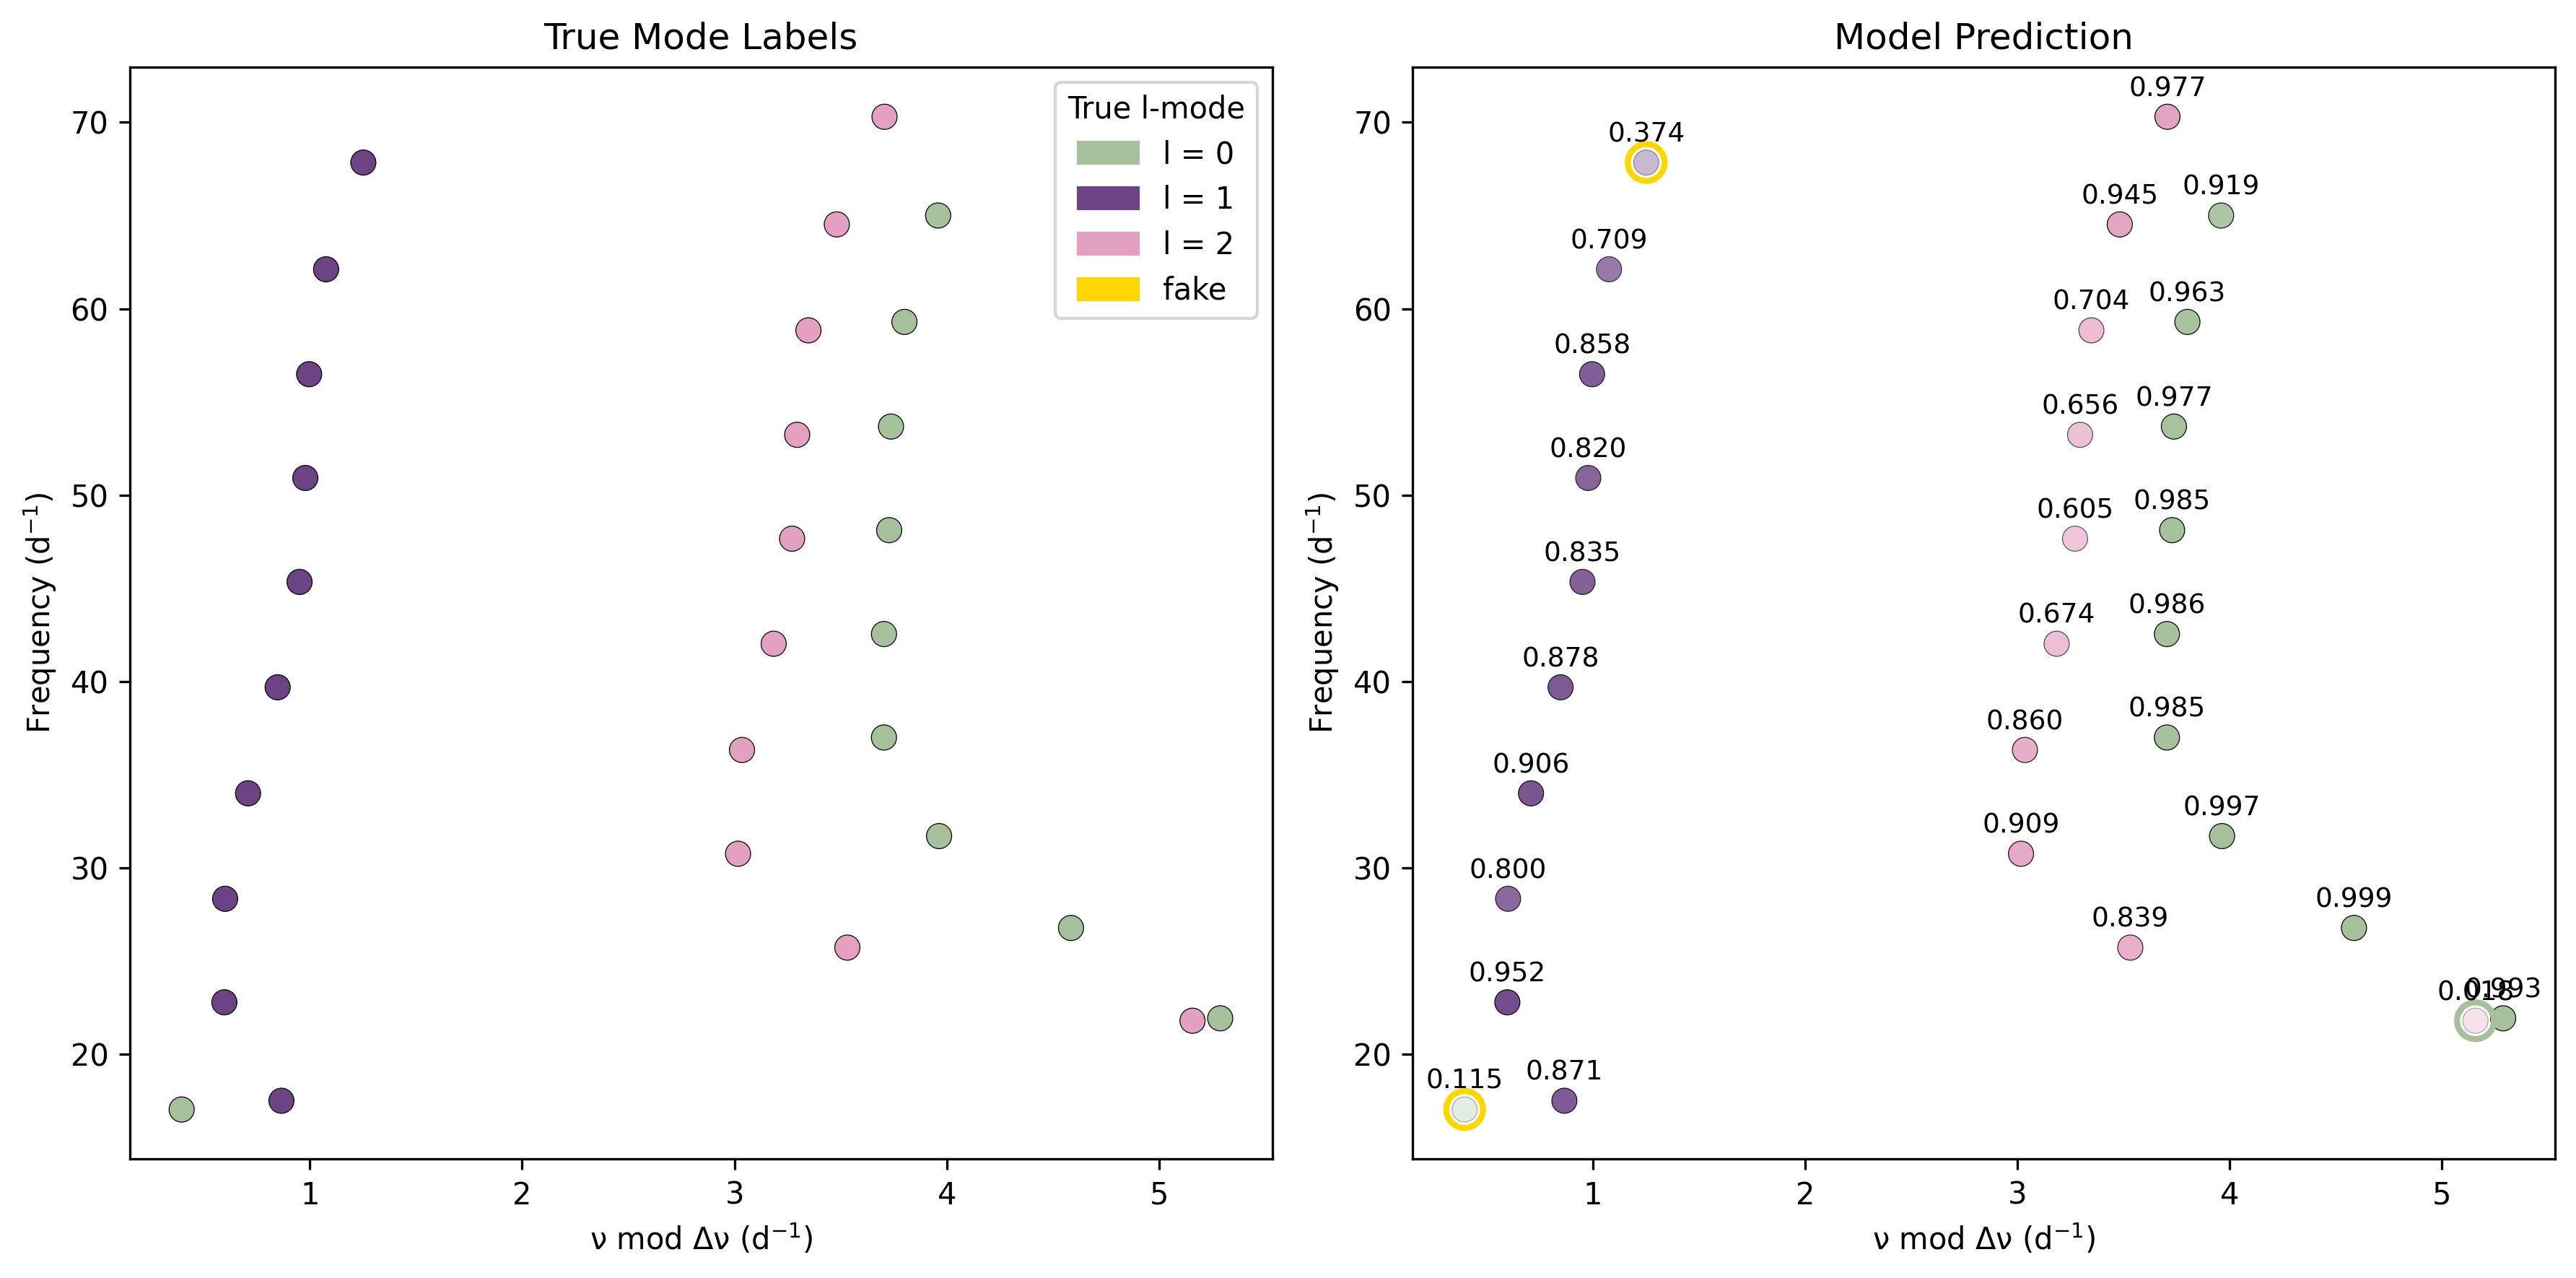

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

REAL_CLASSES = [0, 1, 2]
FAKE_CLASS = 'fake'
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', FAKE_CLASS: 'gold'}
marker_size = 70

n_models = X_test.shape[0]
model_idx = random.randint(0, n_models - 1)

freqs = X_test[model_idx, :, 1]
powers = X_test[model_idx, :, 0]
labels = y_test[model_idx, :]
logits = output[model_idx].T  # shape: (n_points, num_classes)

valid_mask = labels != -1
freqs = freqs[valid_mask]
powers = powers[valid_mask]
labels = labels[valid_mask]
logits = logits[valid_mask]

labels_display = np.array([l if l in REAL_CLASSES else FAKE_CLASS for l in labels], dtype=object)

logits -= np.max(logits, axis=1, keepdims=True)  # numerical stability
probs = np.exp(logits)
probs /= probs.sum(axis=1, keepdims=True)

preds = np.argmax(probs, axis=1)
preds_display = np.array([p if p in REAL_CLASSES else FAKE_CLASS for p in preds], dtype=object)

probs_true_label = np.array([
    probs[i, l] if l in REAL_CLASSES else 0.0
    for i, l in enumerate(labels)
])

colors_true = [color_map[l] for l in labels_display]
edge_colors_pred = [color_map[l] for l in preds_display]

wrong_mask = preds != labels
wrong_freqs = freqs[wrong_mask]
wrong_powers = powers[wrong_mask]
wrong_edge_colors = np.array(edge_colors_pred)[wrong_mask]

fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Left: True labels
axs[0].scatter(freqs, powers, c=colors_true, edgecolors='black',
               linewidths=0.3, s=marker_size)
axs[0].set_title("True Mode Labels")
axs[0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0].set_ylabel("Frequency (d$^{-1}$)")

legend_elements = [
    mpatches.Patch(color=color_map[0], label='l = 0'),
    mpatches.Patch(color=color_map[1], label='l = 1'),
    mpatches.Patch(color=color_map[2], label='l = 2'),
    mpatches.Patch(color=color_map[FAKE_CLASS], label='fake')
]
axs[0].legend(handles=legend_elements, title="True l-mode", loc="upper right")

# Right: Predictions with alpha and errors highlighted
alpha_vals = np.clip(probs_true_label, 0.3, 1.0)

# Base scatter: faded based on confidence
axs[1].scatter(freqs, powers, c=colors_true, alpha=alpha_vals,
               edgecolors='black', linewidths=0.3, s=marker_size)

# Highlight only misclassified points
axs[1].scatter(wrong_freqs, wrong_powers, facecolors='none',
               edgecolors=wrong_edge_colors, linewidths=2.0, s=marker_size + 80)

# Add confidence text
for i in range(len(freqs)):
    axs[1].text(freqs[i], powers[i] + 0.8, f"{probs_true_label[i]:.3f}",
                fontsize=9, ha='center', va='bottom', color='black')

axs[1].set_title("Model Prediction")
axs[1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1].set_ylabel("Frequency (d$^{-1}$)")

plt.tight_layout()
plt.show()